In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

# from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [2]:
df_train = pd.read_csv("DaniDatasets/preprocessed.csv", index_col=0)
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [24]:
d_pre = [i for i in df_train.columns if i != 'time' and i != 'event']

In [21]:
print(pd.read_csv("DaniDatasets/indices_for_preprocessed.csv"))

   index
0      0
1      4
2   2001
3   2489
4   3190
5   5466
6   5589
7   7038
8   8378


In [86]:
omica1 = d_pre[:2]
omica2 = d_pre[2:(2001-2)]
omica3 = d_pre[(2001-2):(2489-2)]
omica4 = d_pre[(2489-2):(3190-2)]
omica5 = d_pre[(3190-2):(5466-2)]
omica6 = d_pre[(5466-2):(5589-2)]
omica7 = d_pre[(5589-2):(7038-2)]
omica8 = d_pre[(7038-2):]

In [146]:
d = omica3 + omica4 + omica5 + omica6
len(d)

3588

In [147]:
#cols_standardize = ['AGE', 'GENDER']
cols_standardize = d

cols_leave = []

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [148]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [149]:
get_target = lambda df: (df['time'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [150]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [151]:
model = CoxPH(net, tt.optim.Adam)

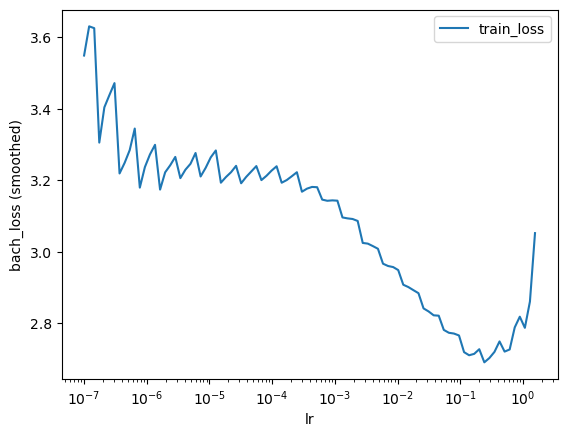

In [152]:
batch_size = 64
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [153]:
lrfinder.get_best_lr()

0.024201282647943603

In [154]:
model.optimizer.set_lr(0.01)

In [155]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

# %%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 3.2919,	val_loss: 3.7148
1:	[0s / 0s],		train_loss: 2.8962,	val_loss: 3.6427
2:	[0s / 0s],		train_loss: 2.6923,	val_loss: 3.6017
3:	[0s / 0s],		train_loss: 2.6149,	val_loss: 3.5552
4:	[0s / 0s],		train_loss: 2.5200,	val_loss: 3.6317
5:	[0s / 0s],		train_loss: 2.3171,	val_loss: 3.7015
6:	[0s / 0s],		train_loss: 2.2746,	val_loss: 3.6491
7:	[0s / 0s],		train_loss: 1.9945,	val_loss: 3.8330
8:	[0s / 0s],		train_loss: 2.0392,	val_loss: 4.0753
9:	[0s / 0s],		train_loss: 1.8283,	val_loss: 4.3524
10:	[0s / 0s],		train_loss: 2.0643,	val_loss: 4.3472
11:	[0s / 0s],		train_loss: 1.8181,	val_loss: 4.3182
12:	[0s / 0s],		train_loss: 1.6985,	val_loss: 4.3023
13:	[0s / 0s],		train_loss: 1.7426,	val_loss: 4.4244


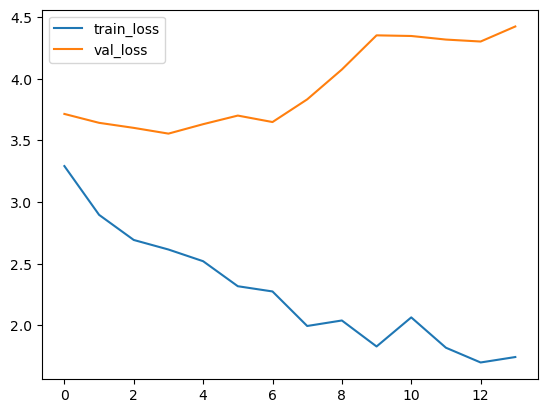

In [156]:
_ = log.plot()

In [157]:
model.partial_log_likelihood(*val).mean()

-3.5551517

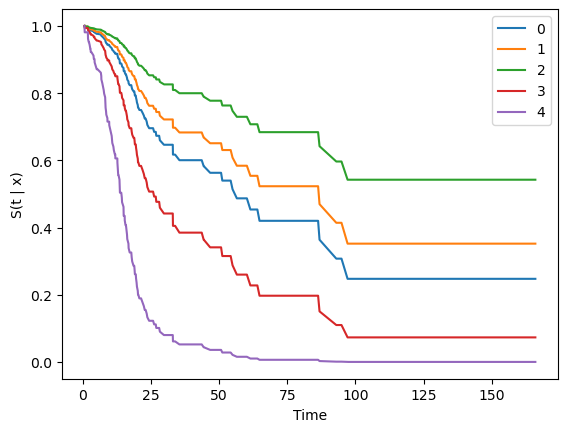

In [158]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [159]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [160]:
ev.concordance_td()

0.6239067055393586

In [161]:
## 0.55 on all omics

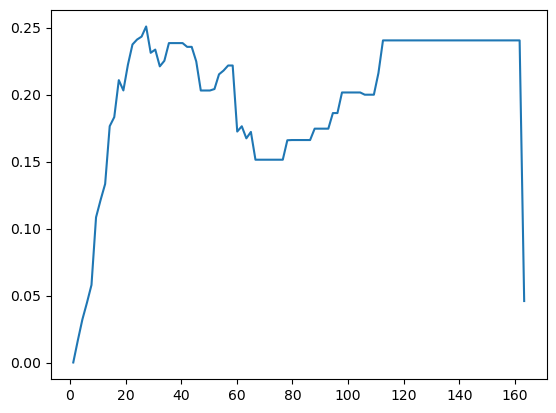

In [162]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [163]:
0.597 1
0.595 12
0.595 123
0.582 13
0.622 1345
0.590 13456


SyntaxError: invalid syntax (2473138011.py, line 1)